In [208]:
# clear toutes les variables
%reset -f

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import grad 
import pandas as pd

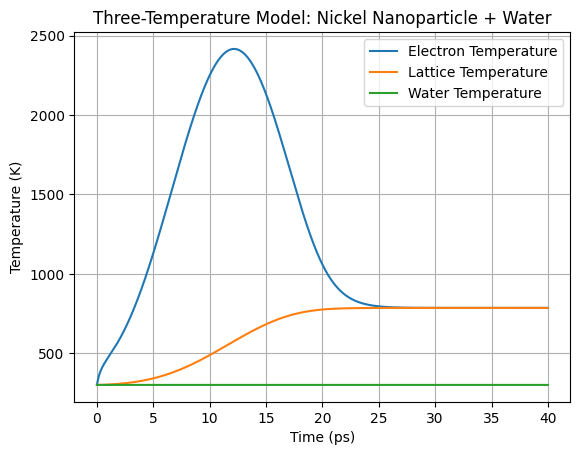

In [210]:
# Constants (SI units)
K_B = 1.380649e-23  # Boltzmann constant, J/K
C_e_coeff = 100     # J/(m^3*K^2)  -> Ce(Te) = C_e_coeff * Te
C_i = 4.5e6         # Lattice heat capacity, J/(m^3*K)
C_w = 4.184e6       # Heat capacity of water, J/(m^3*K)
gamma = 1e17        # Electron-phonon coupling constant, W/(m^3*K)
h = 1e5             # Heat transfer coefficient to water, W/(m^2*K)

T_m = 300           # Initial temperature, K
radius = 5e-9
area = np.pi * (radius**2)
volume = (4/3) * np.pi * (radius**3)
water_volume = (4/3) * np.pi * ((radius * 2)**3) - volume

def generate_data(
    fluence=300,          # J/m^2  (30 mJ/cm^2) , laser fluence
    tau=1e-11,            # s  ,pulse duration (100 fs)
    wavelength=400e-9,    # m  , laser wavelength
    n=2.3,                # refractive index (Nickel, approx)
    k=3.5,                # extinction coefficient
    t_end=40e-12,         # s, simulate up to 60 ps
    steps_per_tau=1600      # time resolution: dt = tau / steps_per_tau
):
    # optical props
    epsilon = (n + 1j * k)**2
    epsilon_m = 1.77  # water dielectric
    sigma_abs = ((8 * np.pi**2 * radius**3) / wavelength) * np.imag((epsilon - epsilon_m) / (epsilon + 2 * epsilon_m))

    # time axis
    time_step = tau / steps_per_tau
    time = np.arange(0, t_end, time_step)

    # laser pulse (Gaussian centered around t = tau)
    def gaussian_pulse(t):
        return (fluence / (tau * np.sqrt(np.pi / np.log(2)))) * np.exp((-4 * np.log(2) * (t - tau)**2) / tau**2)

    intensity = gaussian_pulse(time)
    Q = (sigma_abs * intensity) / volume  # W/m^3

    # init temps
    Te = np.zeros(len(time)); Ti = np.zeros(len(time)); Tw = np.zeros(len(time))
    Te[0] = T_m; Ti[0] = T_m; Tw[0] = T_m

    # explicit update
    for i in range(0, len(time) - 1):
        C_e = C_e_coeff * Te[i]
        dt = time_step

        Te[i + 1] = Te[i] + (dt / C_e) * (-gamma * (Te[i] - Ti[i]) + Q[i] - h * (Te[i] - Tw[i]))
        Ti[i + 1] = Ti[i] + (dt / C_i) * (gamma * (Te[i] - Ti[i]) - h * (Ti[i] - Tw[i]))
        Tw[i + 1] = Tw[i] + (dt / C_w) * (h * (Ti[i] - Tw[i]) * volume / water_volume)

        # clamp to non-negative
        Te[i + 1] = max(Te[i + 1], 0.0)
        Ti[i + 1] = max(Ti[i + 1], 0.0)
        Tw[i + 1] = max(Tw[i + 1], 0.0)
    
    return time, Te, Ti, Tw, sigma_abs

time, Te, Ti, Tw, sigma_abs = generate_data(fluence=300,tau=1e-11,wavelength=400e-9)
# Plotting the results
plt.plot(time / (1e-12), Te, label="Electron Temperature")
plt.plot(time / (1e-12), Ti, label="Lattice Temperature")
plt.plot(time / (1e-12), Tw, label="Water Temperature")

plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Three-Temperature Model: Nickel Nanoparticle + Water")
plt.legend()
plt.grid(True)
plt.show()

In [211]:
data = pd.DataFrame({
    "time_s": time,
    "T_e_K": Te,
    "T_l_K": Ti,
    "T_w_K": Tw,
})

Logs

In [212]:
def log(msg): 
    from datetime import datetime
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

Split data

In [213]:
X = data[["time_s"]].values.astype(np.float32)
y = data[["T_e_K", "T_l_K", "T_w_K"]].values.astype(np.float32)

N = len(X)   # total number of samples
n_train = int(0.60 * N)
n_val   = int(0.20 * N)
n_test  = N - n_train - n_val
log(f"Total samples: {N} (train: {n_train}, val: {n_val}, test: {n_test})")
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val     = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
X_test, y_test   = X[n_train + n_val:], y[n_train + n_val:]

[14:31:26] Total samples: 6400 (train: 3840, val: 1280, test: 1280)


Normalisation des données 

In [214]:
from sklearn.preprocessing import StandardScaler
# normalise t ∈ [0,1] selon train
t_max = float(X_train.max())
X_train_s = X_train / t_max
X_val_s   = X_val   / t_max
X_test_s  = X_test  / t_max

# standardise les 3 sorties (fit sur train seulement)
y_scaler = StandardScaler().fit(y)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

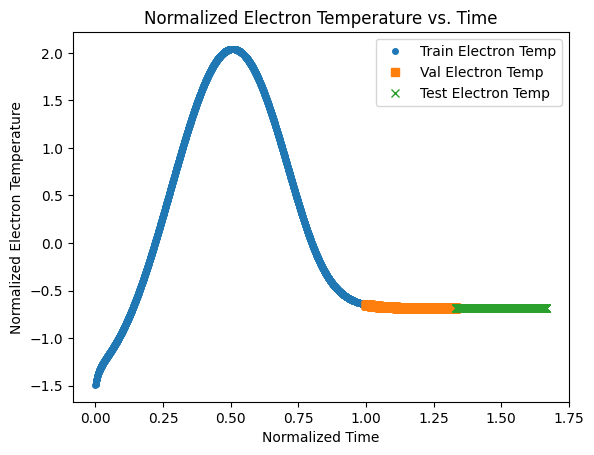

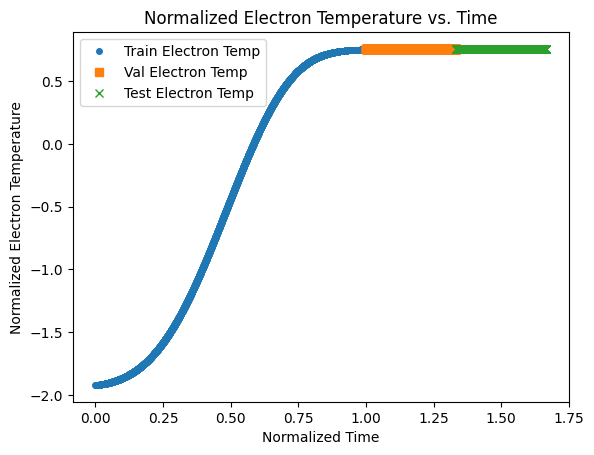

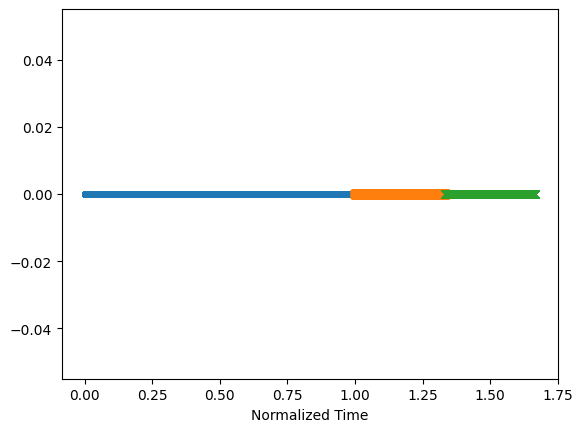

In [215]:
# representation des données normalisées
plt.figure(1)
plt.plot(X_train_s, y_train_s[:, 0], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 0], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 0], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Electron Temperature')
plt.legend()
plt.title('Normalized Electron Temperature vs. Time')
plt.figure(2)
plt.plot(X_train_s, y_train_s[:, 1], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 1], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 1], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Electron Temperature')
plt.legend()
plt.title('Normalized Electron Temperature vs. Time')
plt.figure(3)
plt.plot(X_train_s, y_train_s[:, 2], 'o', label='Train Electron Temp', markersize=4)
plt.plot(X_val_s, y_val_s[:, 2], 's', label='Val Electron Temp', markersize=6)
plt.plot(X_test_s, y_test_s[:, 2], 'x', label='Test Electron Temp', markersize=6)
plt.xlabel('Normalized Time')   
plt.show()

In [216]:
# Datasets et DataLoaders 
class TimeTempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = TimeTempDataset(X_train_s, y_train_s)
val_ds   = TimeTempDataset(X_val_s,   y_val_s)
test_ds  = TimeTempDataset(X_test_s,  y_test_s)

train_loader = DataLoader(train_ds, batch_size=64,shuffle=True)  # schuffle est important pour le training parce que les données sont ordonnées dans le temps
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=True)

In [217]:
import random
# Reproductibilité - Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device (GPU/CPU) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Usingggg device: {device}")

 Usingggg device: cpu


MLP Simple

In [218]:
# Modèle MLP 
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64,64), out_dim=3):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = MLP().to(device)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
log(f"MLP initialisé → {params_count} paramètres entraînables sur {device}")

[14:31:27] MLP initialisé → 4483 paramètres entraînables sur cpu


Fonction du physical loss

In [219]:
def time_derivative(T, t):
    """
    Calcule dT/dt par autograd.
    
    T : sortie du modèle (tensor)
    t : temps d'entrée du modèle (tensor) avec requires_grad=True
    """
    dT_dt = torch.autograd.grad(
        outputs=T,
        inputs=t,
        grad_outputs=torch.ones_like(T),
        create_graph=True,
        retain_graph=True
    )[0]
    
    return dT_dt


def physical_loss3(model, device, Ce_coef=100, Cl=4.5e6, Cm=4.184e6, G=gamma, h=1e5, 
                   n_collocation=200, fluence=300, tau=1e-11):
    """
    Physical loss avec normalisation cohérente.
    """
    # Collocation points NORMALISÉS [0, 1] comme vos données d'entrée
    ts = torch.linspace(0, 1, steps=n_collocation, device=device).view(-1,1)
    ts.requires_grad_(True)
    
    # Convertir en temps réel pour la gaussienne
    t_max = 40e-12  # temps max de vos données
    ts_real = ts * t_max
    
    # Gaussian pulse avec PyTorch
    sqrt_factor = torch.sqrt(torch.tensor(torch.pi / torch.log(torch.tensor(2.0)), device=device))
    log2 = torch.log(torch.tensor(2.0, device=device))
    
    intensity = (fluence / (tau * sqrt_factor)) * torch.exp((-4 * log2 * (ts_real - tau)**2) / tau**2)
    Q = (sigma_abs * intensity) / volume
    
    # Clip Q pour éviter les valeurs trop grandes
    Q = torch.clamp(Q, max=1e15)  # limite raisonnable
    
    # Prédictions (normalisées)
    preds = model(ts)
    Te = preds[:, 0:1]
    Tl = preds[:, 1:2]
    Tw = preds[:, 2:3]
    
    # Dérivées (par rapport au temps normalisé)
    dTe_dt = time_derivative(Te, ts)
    dTl_dt = time_derivative(Tl, ts)
    dTw_dt = time_derivative(Tw, ts)
    
    # Facteur de correction temporel (dt_real = t_max * dt_norm)
    # time_scale = t_max
    time_scale = t_max
    
    # Résidus physiques (version simplifiée/normalisée)
    # Diviser par des facteurs de mise à l'échelle pour stabiliser
    scale_factor = 1e12  # facteur d'échelle pour stabiliser
    
    Re = dTe_dt / time_scale - (1.0 / (Ce_coef * 300)) * (-G * (Te - Tl) + Q / scale_factor)
    Rl = dTl_dt / time_scale - (1.0 / Cl) * (G * (Te - Tl) - h * (Tl - Tw))
    Rw = dTw_dt / time_scale - (1.0 / Cm) * (h * (Tl - Tw) * volume / water_volume)
    
    # Loss
    loss = torch.mean(Re ** 2) + torch.mean(Rl ** 2) + torch.mean(Rw ** 2)
    
    return loss


Comparaison de résultat de modèle sans PINN et avec PINN

L'entrainement du modèle sans PINN

In [220]:
# Entraînement 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#lambda_phys = 0.1  # pondération de la loss physique
n_epochs = 100
history = {"train": [], "val": [], "test": []}
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss_data = criterion(outputs, y_batch)
        #loss_phys = physics_loss(model)
        loss = loss_data #+ lambda_phys* loss_phys  # pondération de la loss physique

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        # train_loss += loss.item() * len(X_batch)


    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # val_loss += loss.item() * X_batch.size(0)
            val_loss += loss.item() * len(X_batch)
    val_loss /= len(val_loader.dataset)

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    # Test final 
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * len(X_batch)
    test_loss /= len(test_loader.dataset)  
    history["test"].append(test_loss)
    log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Test Loss: {test_loss:.6f}")
    # log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")




[14:31:27] Epoch [1/100] - Train Loss: 0.592802, Val Loss: 0.397256, Test Loss: 0.456366
[14:31:27] Epoch [2/100] - Train Loss: 0.310616, Val Loss: 0.355763, Test Loss: 0.661115
[14:31:27] Epoch [3/100] - Train Loss: 0.165573, Val Loss: 0.199152, Test Loss: 0.856336
[14:31:27] Epoch [4/100] - Train Loss: 0.050450, Val Loss: 0.500902, Test Loss: 2.306477
[14:31:27] Epoch [5/100] - Train Loss: 0.014564, Val Loss: 0.774110, Test Loss: 3.379673
[14:31:27] Epoch [6/100] - Train Loss: 0.010052, Val Loss: 0.847584, Test Loss: 3.735401
[14:31:28] Epoch [7/100] - Train Loss: 0.008590, Val Loss: 0.968313, Test Loss: 4.102474
[14:31:28] Epoch [8/100] - Train Loss: 0.007646, Val Loss: 0.988851, Test Loss: 4.212972
[14:31:28] Epoch [9/100] - Train Loss: 0.007175, Val Loss: 0.948553, Test Loss: 4.167707
[14:31:28] Epoch [10/100] - Train Loss: 0.006793, Val Loss: 0.919325, Test Loss: 4.131065
[14:31:28] Epoch [11/100] - Train Loss: 0.006439, Val Loss: 0.916103, Test Loss: 4.136307
[14:31:28] Epoch [1

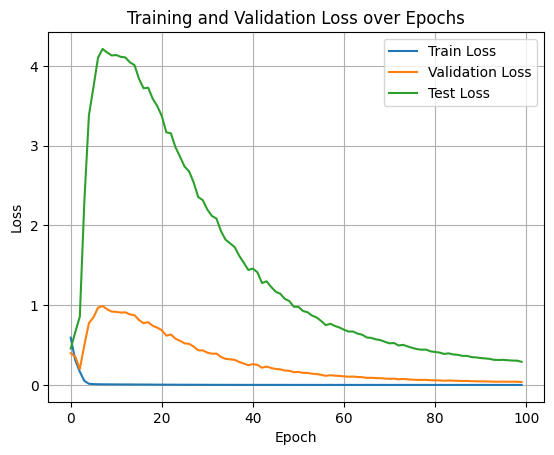

In [221]:
# Representation des courbes d'apprentissage
plt.plot(history["train"], label="Train Loss")
plt.plot(history["val"], label="Validation Loss")
plt.plot(history["test"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Interprétation sans PINN :
- On voit très bien à l'aide des courbes de représentation que notre "validation_loss" et toujours supérieur dans toutes les epochs, par rapport à la "train_loss"
- cela signifie que notre modèle n'arrive pas bien à généraliser sur tous les ensembles de données de validation (inconnus) non-utilisées pour entrainer le modèle , mais juste pour vérifier le modèle

# Entrainement du modèle avec PINN

In [222]:
# Entraînement 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer =torch.optim.
lambda_phys = 1e-23  # pondération de la loss physique
n_epochs = 100
history1 = {"train": [], "val": [],"test": []}
for epoch in range(n_epochs):
    model.train()
    train_loss1 = 0.0
    for X_batch1, y_batch1 in train_loader:
        X_batch1, y_batch1 = X_batch1.to(device), y_batch1.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch1)
        loss_data = criterion(outputs, y_batch1)
        # loss_phys = physic_loss3(model,device)
        loss_phys=physical_loss3(model,device)
        loss = loss_data + lambda_phys* loss_phys  # pondération de la loss physique

        loss.backward()
        optimizer.step()
        # train_loss += loss.item() * X_batch.size(0)
        train_loss1 += loss.item() * len(X_batch1)


    train_loss1 /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss1 = 0.0
    with torch.no_grad():
        for X_batch1, y_batch1 in val_loader:
            X_batch1, y_batch1 = X_batch1.to(device), y_batch1.to(device)
            outputs = model(X_batch1)
            loss_val = criterion(outputs, y_batch1)
            loss = loss_val + lambda_phys* loss_phys  # pondération de la loss physique

            # val_loss += loss.item() * X_batch.size(0)
            val_loss1 += loss.item() * len(X_batch1)
    val_loss1 /= len(val_loader.dataset)

    history1["train"].append(train_loss1)
    history1["val"].append(val_loss1)


    # Test final 
    model.eval()
    test_loss1 = 0.0
    with torch.no_grad():
        for X_batch1, y_batch1 in test_loader:
            X_batch1, y_batch1 = X_batch1.to(device), y_batch1.to(device)
            outputs = model(X_batch1)
            loss_test = criterion(outputs, y_batch1)
            loss = loss_test + lambda_phys* loss_phys  # pondération de la loss physique
            test_loss1 += loss.item() * len(X_batch1)
    test_loss1 /= len(test_loader.dataset)  
    history1["test"].append(test_loss1)
    log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss1:.6f}, Val Loss: {val_loss1:.6f}, Test Loss: {test_loss1:.6f}")
    # log(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {train_loss1:.6f}, Val Loss: {val_loss1:.6f}")

C:\Users\ainar\AppData\Local\Temp\ipykernel_29672\1811871760.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_factor = torch.sqrt(torch.tensor(torch.pi / torch.log(torch.tensor(2.0)), device=device))


[14:31:41] Epoch [1/100] - Train Loss: 68.885196, Val Loss: 12.707865, Test Loss: 12.678235
[14:31:41] Epoch [2/100] - Train Loss: 5.972385, Val Loss: 2.658378, Test Loss: 2.687181
[14:31:41] Epoch [3/100] - Train Loss: 1.758327, Val Loss: 1.081449, Test Loss: 1.117705
[14:31:42] Epoch [4/100] - Train Loss: 0.951625, Val Loss: 0.750810, Test Loss: 0.788475
[14:31:42] Epoch [5/100] - Train Loss: 0.758012, Val Loss: 0.654783, Test Loss: 0.691954
[14:31:42] Epoch [6/100] - Train Loss: 0.684431, Val Loss: 0.611978, Test Loss: 0.648412
[14:31:43] Epoch [7/100] - Train Loss: 0.644446, Val Loss: 0.583402, Test Loss: 0.619714
[14:31:43] Epoch [8/100] - Train Loss: 0.619119, Val Loss: 0.561220, Test Loss: 0.598151
[14:31:43] Epoch [9/100] - Train Loss: 0.603314, Val Loss: 0.544408, Test Loss: 0.582702
[14:31:44] Epoch [10/100] - Train Loss: 0.592762, Val Loss: 0.529666, Test Loss: 0.571395
[14:31:44] Epoch [11/100] - Train Loss: 0.586240, Val Loss: 0.517652, Test Loss: 0.563229
[14:31:44] Epoch

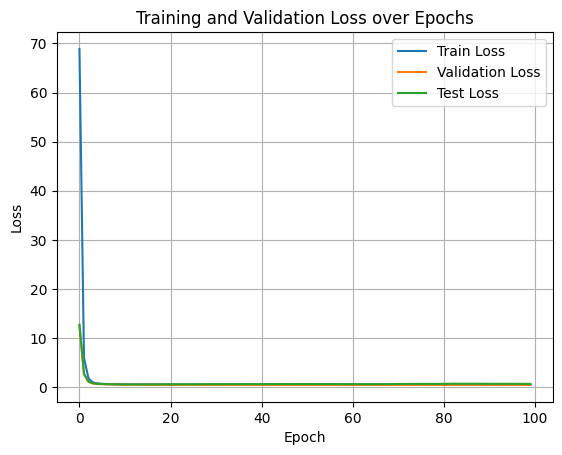

In [223]:
# Representation des courbes d'apprentissage
plt.plot(history1["train"], label="Train Loss")
plt.plot(history1["val"], label="Validation Loss")
plt.plot(history1["test"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Interprétation avec PINN: 
- Après avoir tester l'entrainement du modèle avec PINN, on a pu résoudre le problème de généralisation de notre modèle sur l'ensemble des données de validation (des données inconnues) , cela montre bien l'efficacité de la stabilisation de la "physical_loss" par rapport au "data_loss  sans PINN " 